# SYDE 552 Assignment 3: Hippocampal Models
### Due Monday, March, Anywhere on Earth 
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with associative memories. To do so, we'll be using pytorch to implement different associative memory models.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Hippocampus

**1.a) [2 marks]** The hippocampus is implicated in spatial navigation and episodic memory.  How do we know this?  What are some of the neuroscience results that revealed these facilities of the hippocampus?  (see Kandel *et al.* Ch. 65)

**Episodic Memory**

One straightforward demonstration of the hippocampus' involvement in episodic memory is the case of H.M. In the 1950s, H.M. had his hippocampus removed as a treatment for epilepsy which treated his seizures but also inhibited his ability to form memories, "What H.M. now lacked, and lacked dramatically, was the ability to transfer new information from working memory into long-term memory. He was unable to retain for lengthy periods information about people, places, or objects that he had just encountered". H.M. was a clear demonstation of the importance that the hippocampus has to episodic memory. 

This was further strengthened through fMRI imaging  when Wagner et al. found that there was greater activity in the medial temporal lobe (which includes the hippocampus) when participants were encoding stimuli that was later remembered.

Source: Kandel et al. Ch. 65

**Spatial Navigation**

Additionally, it was found that the hippocampus contained place cells which are involved in mapping the spatial world by John O'Keefe and John Dostrovsky in 1971. The place cells were found to fire when a mouse enters a particular location. The place cells identify particular landmarks or locations of interest within the environment that are relevant to the animal. 

Another piece of the spatial navigation puzzle are grid cells. Discovered by Moser et al. in 2005, grid cells fire periodically in space to help perform path integration. Grid cells are arranged in a hexagonal grid across a range of scales and orientations which can be combnined to form a detailed grid of places.

Source: Kandel et al. Ch. 67

**1.b) [2 marks]** The Gluck and Meyers model of hippocampus is a simple, effective model of hippocampus, and how representations may be constructed for the slow transfer to the neocortex.  However, it still has its limitations.  Explain some (two or more) of the limitations of the Gluck and Meyers model.  (The Gluck and Meyers Ch.6 reading will be useful in answering this question.) 

The Gluck and Meyers model of hippocampus models the hippocampus as a, "predictive autoencoder, mapping from stimulus inputs, through an internal layer, to outputs that reconstruct those inputs and also predict future reinforcement". In their model, the representations learned by the hippocampal autoencoder structure are then used by the cortex and cerebellum for longer term storage.

One limitation of this model is that the autoencoder in continually learning as it receives new inputs which means its representations are continuously evolving. However these representations are being used to store information in the cortex which means that in order to access those long-term memories, the brain would need the ability to decode every learned representation. This seems like it would be a very difficult task for the brain to develop a 'universal' decoder for accessing long term memories which are all encoded differently.

Additionally, Gluck and Meyers' model doesn't provide substantive explanation for how the autoencoder structure would be implemented biologically. It is taken as a given that the model could be implemented in neural circuits but doesn't address some of the unique limitations of neurons like refractory periods, short-term adaptation, cells dying. 

Source: Gluck and Meyers Ch. 6

**1.c) [2 mark]** Unsupervised pre-training is integral to the Gluck and Meyers model of Hippocampus, and unsupervised pre-training has been shown to accelerate reinforcement learning in rats navigating mazes.  However, unsupervised pre-training is not common in deep learning techniques.  Describe why that may be.  (See [$\S 15.1$ of Goodfellow *et al.*](https://www.deeplearningbook.org/contents/representation.html))

As discussed in Goodfellow et al. unsupervised pre-training is not common in deep learning techniques because while it can improve performance in some cases there is also a risk of harming the performance.
One challenge with a pre-training phase preceding a fine-tuning phase is that both phases need to be optimized in order to maximize performance and it is difficult to update the whole system holistically. Additionally, the theory behind unsupervised pre-training is that the pre-training algorithm will find a more effective representation of the data to be uised in a later task but there is no guarantee that the representation which is discovered will actually be better. Self-supervised pre-training has become much more common, for example using masked language modelling to pre-train large transformer models, the representations learned here are more likely to be useful for the downstream task because they are informed by the pre-training task of predicting masked tokens.

Source: Goodfellow et al. Ch. 15

# 2. Hopfield Networks

## Preliminaries

Although you should have installed them for prior assignments, we will require the pytorch and keras. Let's install those now/

```pip install torch keras```

Next, we will download the MNIST dataset.  We will do this through the Keras library instead of torchvision. 

In [6]:
import torch
# Configure to run on mac m1 chip
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
DEVICE

'mps'

In [7]:
import keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

As before, we will examine some of the images to make sure we got them right.

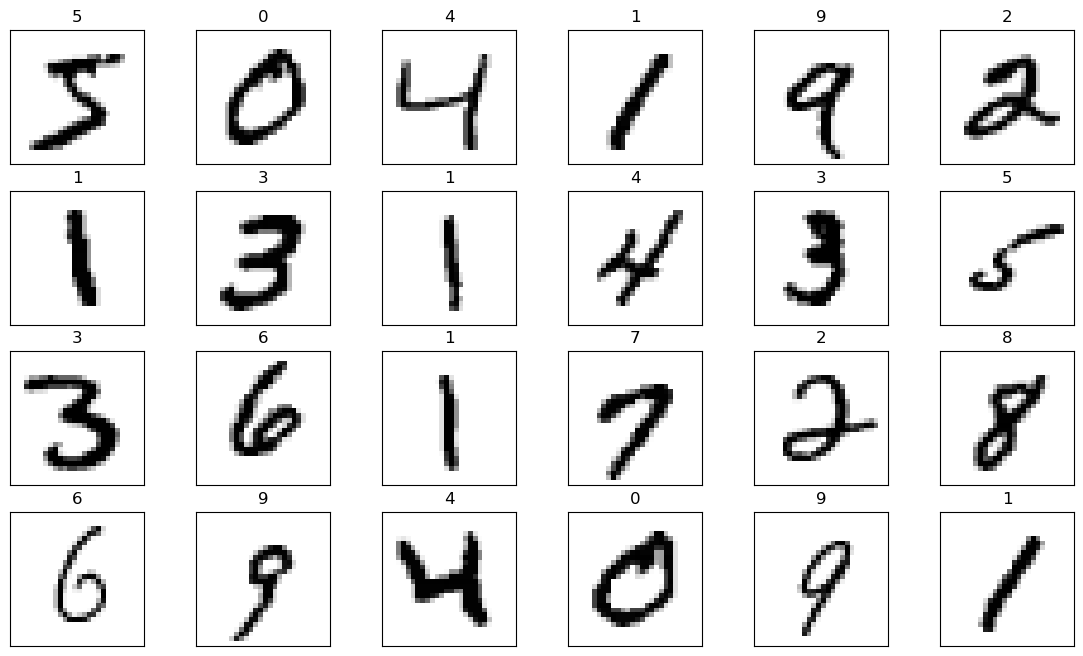

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(x_train[i].reshape((28,28)), vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

Normally, the MNIST dataset has images represented by values in the range $[0,255]$. However, since we are dealing with Hopfield networks, we are going to binarize the data.

In [9]:
def binarize(xs):
    '''
    xs : a num_samples by num_features array of images.
    '''
    binary = (xs / 255) > 0.5
    integer = 2 * binary - 1
    return integer

binary_imgs = binarize(x_train)


Further, to make things easy on our network, we are only going to look at images of the digits 0, 1, and 2

In [10]:
binary_imgs = binary_imgs[y_train < 3,:]

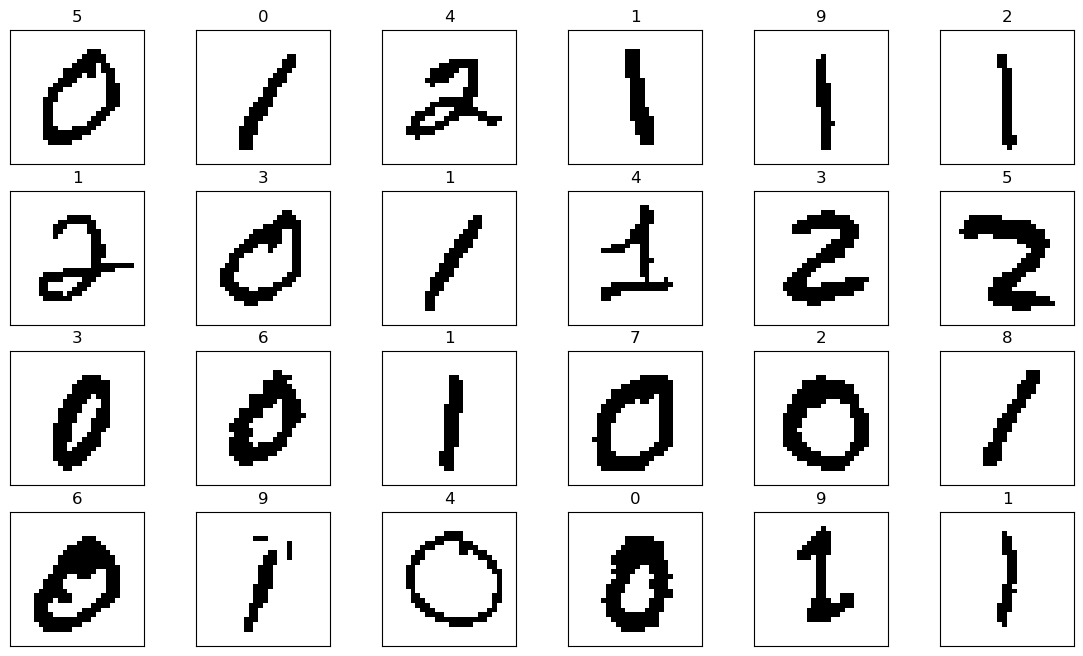

In [11]:
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

We will also need to reshape the data into a vector representation, and then covert it to a pytorch tensor

In [12]:
binary_img_vecs = binary_imgs.reshape((-1,28*28))
binary_img_tensor = torch.from_numpy(binary_img_vecs).to(torch.float32)


**2.a) [2 Marks]**  Implement the Hopfield Network using Hopfield's learning rule.

We will first implement the Hopfield network using the outer product formulation for the weight matrix.  Given a set of patterns $\mathbf{x}_{i}$, by first computing the matrix

$ D = \frac{1}{N}\sum_{i}^{N} (\mathbf{x}_{i}-\theta)(\mathbf{x}_{i}-\theta)^T $.

where $\theta = \frac{1}{ND}\sum_{i}^{N}\sum_{j}^{D} x_{i,j}$, i.e., the average value of all elements in the training data.

Next we remove the diagonal element of the matrix, making the weight matrix:

$$
W = D - \mathrm{diag}(D),
$$

where $\mathrm{diag}(D)$ is the diagonal of the $D$ matrix.  Note that when implementing this in numpy or pytorch we must apply the ```diag``` function twice, i.e.:

```
W = D - torch.diag(torch.diag(D))

```

Here is some code to implement the learning rule:

In [13]:
import torch
def outer_product_hopfield_matrix(training_patterns):
    '''
    train_hopfield_matrix - produces a matrix for a (non-Modern) Hopfield network using the outer product rule.
    
    Parameters:
    -----------
    
    training_patterns : torch.Tensor
    
        A Tensor of shape (num_patterns, num_features) that will be used to construct the weight matrix.
        
    Returns:
    --------
    
    W : torch.Tensor
    
        A (num_features, num_features) Tensor that stores the papers encoded in the network.
    '''
    theta = torch.sum(training_patterns) / (training_patterns.shape[0] * training_patterns.shape[1])
    D = torch.einsum('nd,ne->de', training_patterns - theta, training_patterns - theta) / float(training_patterns.shape[0])
    W = (D - torch.diag(torch.diag(D))) 
    return W
    
def evaluate_hopfield_network(W, input_pattern, training_patterns=None, num_iters = 5, threshold=0):
    '''
    Evaluates a Hopfield network with weight matrix W on a number of tets patterns.  Also computed the similarity 
    '''
    assert input_pattern.shape[0] == 1, f'''This function assumes you are cleaning up one pattern at a time. 
                                            Expected the input to be shape (1,{input_pattern.shape[1]}), 
                                            got {input_pattern.shape}'''
    s = input_pattern[0]
    
    similarities = None
    if training_patterns is not None:
        similarities = torch.zeros((num_iters, training_patterns.shape[0]))
    ### end if
    
    for i in range(num_iters):
        s = torch.sign(W @ s - threshold)
        
        if training_patterns is not None:
            similarities[i,:] = torch.einsum('d,nd->n',s,training_patterns)
        ### end if
    ### end for
    return s, similarities

We want you to do the following things:

1. Compute the capacity of the network, using the expression $C \approx \frac{d}{2\log_{2}(d)}$, where $d$ is the number of neurons.
2. For a training set of 10 patterns, plot the original image and the reconstructed image side-by-side.
3. Plot the training and test error (Mean squared error between the predicted and true values) of the Hopfield network as a function of the number of patterns stored in the network up to capacity, $C$, for five randomly selected training sets selected from ```binary_img_tensor```.
4. For a training set of size 10 patterns, add salt and pepper noise (bit flips) to the **training** images and compute the training error as the probability of noise increases.

In [14]:
import numpy as np
## 2.a.1 - Compute network capacity.
# Find the number of neurons
d = binary_img_vecs.shape[1]
# Calculate approcimate capacity
C = d / (2 * np.log2(d))
print(f'Capacity is approximately {C}')
C = int(C)
print(f'Capacity truncated is {C}')

Capacity is approximately 40.770861144595855
Capacity truncated is 40


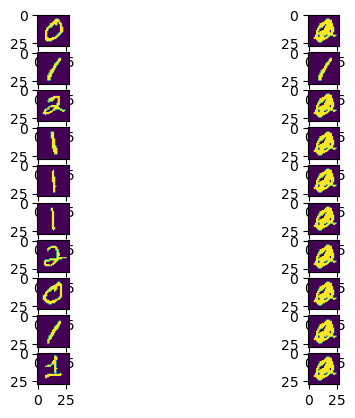

In [145]:
# 2.a.2 - plot original and reconstructed imatges.
plt.figure()
# create weight matrix, W
training_set = binary_img_tensor[:10]
W = outer_product_hopfield_matrix(training_set[:3])
for i in range(10):
    # reconstruct training image, i.
    image_dim = training_set[1].shape[0]
    input_pattern = training_set[i].reshape(1, image_dim)
    reconstructed_img, similarities = evaluate_hopfield_network(W, input_pattern, num_iters=5, threshold=0)
    plt.subplot(10,2,1+2*i)
    # plot original image 
    original_image = input_pattern.reshape(28, 28)
    plt.imshow(original_image)
    plt.subplot(10,2,1+2*i+1)
    # plot reconstructed image.
    reconstructed_img = reconstructed_img.reshape(28, 28)
    plt.imshow(reconstructed_img)

We see above that the reconstructed images from this hopfield network tend to converge to similar outputs regardless of input. The network is converging to a combination of the three training patterns rather than distinguishing between them.

In [19]:
# Prep test data
binary_test_imgs = binarize(x_test)
binary_test_imgs = binary_test_imgs[y_test < 3,:]
binary_test_img_vecs = binary_test_imgs.reshape((-1,28*28))
binary_test_img_tensor = torch.from_numpy(binary_test_img_vecs).to(torch.float32)

In [20]:
# 2.a.3 - Plot training and test error

def mse(true_vals, pred_val):
    return torch.mean((true_vals - pred_val)**2)

def test_network(training_patterns, test_patterns, C):
    assert training_patterns.shape[0] == C, f'''Error: Expected training patterns to contain {C} patterns'''
    training_error = torch.zeros((len(range(2,C)),))
    test_error = torch.zeros((len(range(2,C)),))
    for pattern_idx, num_patterns in enumerate(range(2,C)):
        # print(f'Running test for {num_patterns} patterns')
        # train network
        W = outer_product_hopfield_matrix(binary_img_tensor[:num_patterns,:])
        
        # for each image in the training set, compute the mse
        for train_idx in range(num_patterns):
            train_mse = torch.zeros((num_patterns,))
            input_pattern = training_patterns[train_idx].reshape(1, training_patterns.shape[1])
            reconstructed_img, _ = evaluate_hopfield_network(W, input_pattern, num_iters=10)
            train_mse[train_idx] = mse(input_pattern, reconstructed_img)
        # for each image in the test set, compute the mse
        for test_idx in range(num_patterns):
            test_mse = torch.zeros((num_patterns,))
            input_pattern = test_patterns[test_idx].reshape(1, test_patterns.shape[1])
            reconstructed_img, _ = evaluate_hopfield_network(W, input_pattern, num_iters=10)
            test_mse[test_idx] = mse(input_pattern, reconstructed_img)
        ### end for
        training_error[pattern_idx] = torch.mean(train_mse)
        test_error[pattern_idx] = torch.mean(test_mse)
    ### end for
    return training_error, test_error

# Select 5 random training sets from binary_img_tensor
training_set_size = C
training_runs = torch.zeros((5, C-2))
testing_runs = torch.zeros((5, C-2))
for i in range(5):
    training_set = binary_img_tensor[torch.randperm(binary_img_tensor.shape[0])[:training_set_size],:]
    training_error, test_error = test_network(training_set, binary_test_img_tensor, C)
    training_runs[i] = training_error
    testing_runs[i] = test_error

average_training = torch.mean(training_runs, dim=0)
average_testing = torch.mean(testing_runs, dim=0)

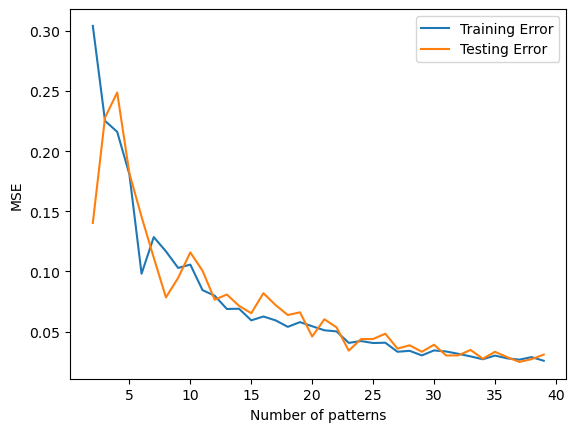

In [21]:
plt.figure()
plt.plot(range(2,C), average_training, label='Training Error')
plt.plot(range(2,C), average_testing, label='Testing Error')
plt.xlabel('Number of patterns')
plt.ylabel('MSE')
plt.legend()

We see that both training and test error decrease as the number of training patterns approaches the saturation point. This may be explained by the model having more diverse patterns for each of the three classes to fit novel data into.

Running test for 0.009999999776482582
Running test for 0.06444444507360458
Running test for 0.11888889223337173
Running test for 0.17333334684371948
Running test for 0.22777779400348663
Running test for 0.2822222113609314
Running test for 0.33666664361953735
Running test for 0.3911111056804657
Running test for 0.44555556774139404
Running test for 0.5


Text(0, 0.5, 'MSE')

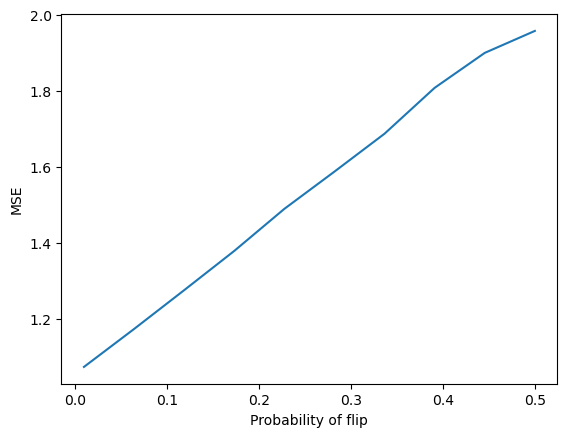

In [147]:
# 2.a.4 - Test salt-and-pepper noise.

num_steps = 10 ### Pick a value
prob_flip = torch.linspace(0.01,0.5,num_steps)

training_data = binary_img_tensor[:25]
testing_data = binary_test_img_tensor[:100]
W = outer_product_hopfield_matrix(training_data)

mses = torch.zeros((num_steps))
for p_idx, p in enumerate(prob_flip):
    print(f'Running test for {p}')
    # Corrupt test data
    noisy_test_data = testing_data.clone()
    flip_mask = torch.rand(noisy_test_data.shape) < p
    noisy_test_data[flip_mask] = -noisy_test_data[flip_mask]
    # for each image in the test set, compute the mse
    test_mse = torch.zeros((testing_data.shape[0],))
    for test_idx in range(testing_data.shape[0]):
        input_pattern = noisy_test_data[test_idx].reshape(1, testing_data.shape[1])
        reconstructed_img, _ = evaluate_hopfield_network(W, input_pattern, num_iters=10)
        test_mse[test_idx] = mse(input_pattern, reconstructed_img)
    average_mse = torch.mean(test_mse)
    mses[p_idx] = average_mse
    pass

plt.figure()
plt.plot(prob_flip, mses)
plt.xlabel('Probability of flip')
plt.ylabel('MSE')

As expected, model performance suffers as the amount of noise increases. It is interesting to note that there appears to be a near linear relationship between MSE and the probability of flipping a bit.

**2.b) [2 Mark]** Train Hopfield network using the pseudo-inverse and repeat the tasks 2.a) 2-4, however, for this example, ensure the threshold value is 0.  Even though the pseudo-inverse has a greater capacity thant he hopfield network, we will still test up to the theoretical capcity of the Hopfield learning rule.

In [24]:
def pseudo_inv(X, lamb=0.01):
    '''
    pseudo_inv - Implements the pseudoinverse from the previous assignment.
    
    Parameters:
    -----------
    
    X : torch.Tensor
        A (num_patterns, num_features) Tensor holding the training data.
        
    lamb : float
        The regularization term for the pseudoinverse
        
    
    Returns:
    --------
    
    The pseudoinverse of X
    '''
    return torch.inverse(X.T@X + lamb * torch.eye(X.shape[1]).float()) @ X.T

def pseudoinverse_hopfield_matrix(training_patterns, lamb = 0.01):
    '''
    pseudoinverse_hopfield_matrix - Uses the regularized pseudoinverse to construct a weight matrix for
        a non-modern Hopfield network.
    
    Parameters:
    -----------
    
    training_patterns : torch.Tensor
        
        The (num_patterns, num_features) Tensor containing the training data.
        
    lamb : float
    
        The regularization term for the pseudo-inverse. 
        
    Returns:
    --------
    
        The weight matrix compatible with the evaluate_hopfield_network function 
    '''
    W = pseudo_inv(training_patterns, lamb=lamb) @ training_patterns
    return W / training_patterns.shape[0]

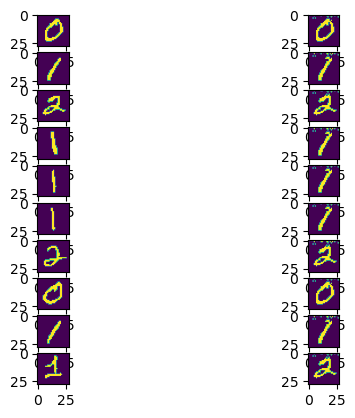

In [24]:
# 2.b.2 - For a training set of 10 patterns, plot the original image and the reconstructed image side-by-side
training_set = binary_img_tensor[:10]
W = pseudoinverse_hopfield_matrix(training_set[:3])
for i in range(10):
    # reconstruct training image, i.
    image_dim = training_set[1].shape[0]
    input_pattern = training_set[i].reshape(1, image_dim)
    reconstructed_img, similarities = evaluate_hopfield_network(W, input_pattern, num_iters=10)
    plt.subplot(10,2,1+2*i)
    # plot original image 
    original_image = input_pattern.reshape(28, 28)
    plt.imshow(original_image)
    plt.subplot(10,2,1+2*i+1)
    # plot reconstructed image.
    reconstructed_img = reconstructed_img.reshape(28, 28)
    plt.imshow(reconstructed_img)

Qualitatively we observe that the pseudo-inverse learning rule for the hopfield network does a much better job at reconstructing images.

In [44]:
# 2.b.3 Plot training and test error
def test_network(training_patterns, test_patterns, C):
    assert training_patterns.shape[0] == C, f'''Error: Expected training patterns to contain {C} patterns'''
    training_error = torch.zeros((len(range(2,C)),))
    test_error = torch.zeros((len(range(2,C)),))
    for pattern_idx, num_patterns in enumerate(range(2,C)):
        # print(f'Running test for {num_patterns} patterns')
        # train network
        W = pseudoinverse_hopfield_matrix(binary_img_tensor[:num_patterns,:])
        
        # for each image in the training set, compute the mse
        for train_idx in range(num_patterns):
            train_mse = torch.zeros((num_patterns,))
            input_pattern = training_patterns[train_idx].reshape(1, training_patterns.shape[1])
            reconstructed_img, _ = evaluate_hopfield_network(W, input_pattern, num_iters=10)
            train_mse[train_idx] = mse(input_pattern, reconstructed_img)
        # for each image in the test set, compute the mse
        for test_idx in range(num_patterns):
            test_mse = torch.zeros((num_patterns,))
            input_pattern = test_patterns[test_idx].reshape(1, test_patterns.shape[1])
            reconstructed_img, _ = evaluate_hopfield_network(W, input_pattern, num_iters=10)
            test_mse[test_idx] = mse(input_pattern, reconstructed_img)
        ### end for
        training_error[pattern_idx] = torch.mean(train_mse)
        test_error[pattern_idx] = torch.mean(test_mse)
    ### end for
    return training_error, test_error

# Select 5 random training sets from binary_img_tensor
training_set_size = C
training_runs = torch.zeros((5, C-2))
testing_runs = torch.zeros((5, C-2))
for i in range(5):
    training_set = binary_img_tensor[torch.randperm(binary_img_tensor.shape[0])[:training_set_size],:]
    training_error, test_error = test_network(training_set, binary_test_img_tensor, C)
    training_runs[i] = training_error
    testing_runs[i] = test_error

average_training = torch.mean(training_runs, dim=0)
average_testing = torch.mean(testing_runs, dim=0)

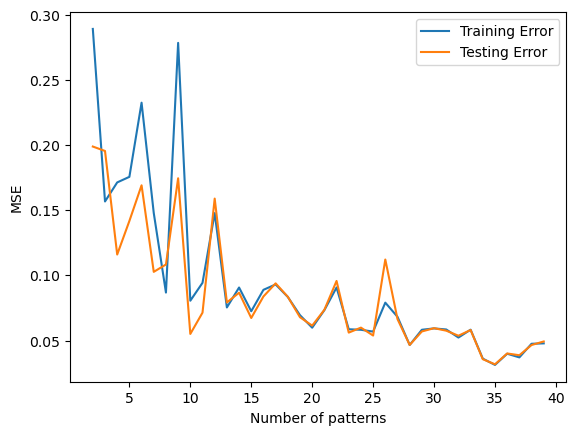

In [45]:
plt.figure()
plt.plot(range(2,C), average_training, label='Training Error')
plt.plot(range(2,C), average_testing, label='Testing Error')
plt.xlabel('Number of patterns')
plt.ylabel('MSE')
plt.legend()

Similar to the outer product hopfield network, MSE decreases as the network encounters more patterns.

Running test for 0.009999999776482582
Running test for 0.06444444507360458
Running test for 0.11888889223337173
Running test for 0.17333334684371948
Running test for 0.22777779400348663
Running test for 0.2822222113609314
Running test for 0.33666664361953735
Running test for 0.3911111056804657
Running test for 0.44555556774139404
Running test for 0.5


Text(0, 0.5, 'MSE')

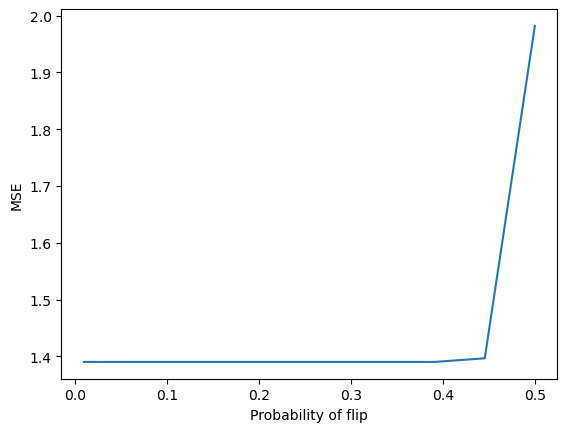

In [150]:
# 2.b.4 - Test salt-and-pepper noise.

num_steps = 10 ### Pick a value
prob_flip = torch.linspace(0.01,0.5,num_steps)

training_data = binary_img_tensor[:25]
testing_data = binary_test_img_tensor[:150]
W = pseudoinverse_hopfield_matrix(training_data)

mses = torch.zeros((num_steps))
for p_idx, p in enumerate(prob_flip):
    print(f'Running test for {p}')
    # Corrupt test data
    noisy_test_data = testing_data.clone()
    flip_mask = torch.rand(noisy_test_data.shape) < p
    noisy_test_data[flip_mask] = -noisy_test_data[flip_mask]
    # for each image in the test set, compute the mse
    test_mse = torch.zeros((testing_data.shape[0],))
    for test_idx in range(testing_data.shape[0]):
        true_input = testing_data[test_idx].reshape(1, testing_data.shape[1])
        input_pattern = noisy_test_data[test_idx].reshape(1, testing_data.shape[1])
        reconstructed_img, _ = evaluate_hopfield_network(W, input_pattern, num_iters=10)
        test_mse[test_idx] = mse(true_input, reconstructed_img)
    average_mse = torch.mean(test_mse)
    mses[p_idx] = average_mse
    pass

plt.figure()
plt.plot(prob_flip, mses)
plt.xlabel('Probability of flip')
plt.ylabel('MSE')

Again, the pseudoinverse method performs worse with more noise, it is interesting to note that the relationship between MSE and noise looks more like an exponential relationship.

**2.c) [1 Mark]** Show how the network behaves when an entire region of the image is corrupted. 

For your best performing network, take three test images and set half of the inputs to be equal to zero.  
Plot the original images, the corrupted images, and the reconstructed images, side-by-side.

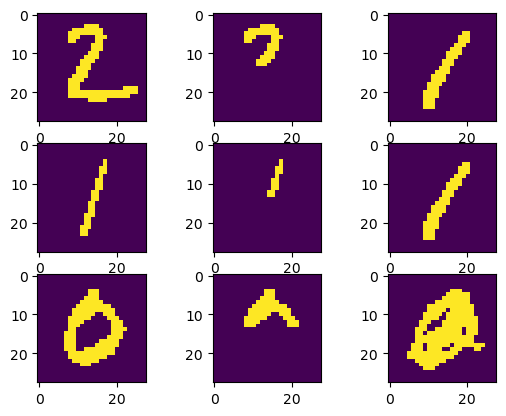

In [159]:
# Your code here
training_set = binary_img_tensor[:3]
W = outer_product_hopfield_matrix(training_set)
test_images = binary_test_img_tensor[:3]
# Corrupt half of the test images
corrupted_test_images = test_images.clone()
corrupted_test_images[:, 392:] = -1
# Plot images, corrupted images, and reconstructed images
for i in range(3):
    plt.subplot(3,3,1+3*i)
    plt.imshow(test_images[i].reshape(28,28))
    plt.subplot(3,3,2+3*i)
    plt.imshow(corrupted_test_images[i].reshape(28,28))
    reconstructed_img, _ = evaluate_hopfield_network(W, corrupted_test_images[i].reshape(1, 784), training_set, 5)
    plt.subplot(3,3,3+3*i)
    plt.imshow(reconstructed_img.reshape(28,28))

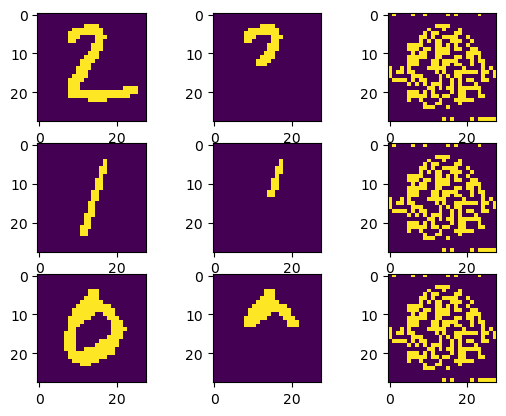

In [157]:
# Your code here
training_set = binary_img_tensor[:35]
W = pseudoinverse_hopfield_matrix(training_set)
test_images = binary_test_img_tensor[:3]
# Corrupt half of the test images
corrupted_test_images = test_images.clone()
corrupted_test_images[:, 392:] = -1
# Plot images, corrupted images, and reconstructed images
for i in range(3):
    plt.subplot(3,3,1+3*i)
    plt.imshow(test_images[i].reshape(28,28))
    plt.subplot(3,3,2+3*i)
    plt.imshow(corrupted_test_images[i].reshape(28,28))
    reconstructed_img, _ = evaluate_hopfield_network(W, corrupted_test_images[i].reshape(1, 784), training_set, 5)
    plt.subplot(3,3,3+3*i)
    plt.imshow(reconstructed_img.reshape(28,28))

We find that even the best performing pseudoinverse hopfield network really struggles with the partially obstructed images, it just produces as noisy shape. The simpler outer product matrix also struggles but produces outputs which are closer to recognizable digits.

# 3. Autoencoders

Now we are going to train an autoencoder to perform the same associative task that we explored above.  We are going to define our Autoencoder using sigmoid neurons, which shouldn't be too terrible, since it is a relatively shallow network, but one is not obligated to use those. 

Because we are going to use a sigmoidal output function, so we should be concerned with values in the range $[0,1]$, instead of $\{-1,1\}$.  Training will be done using the original MNIST images, **not** the binary images.


In [18]:
from torch.utils.data import TensorDataset, DataLoader

x_train_tensor = torch.from_numpy(x_train.reshape((-1,28*28)) / 255).to(torch.float32)
x_test_tensor = torch.from_numpy(x_test.reshape((-1,28*28))/ 255).to(torch.float32)

print(x_train_tensor.dtype)
print(x_test_tensor.dtype)

train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, x_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

torch.float32
torch.float32


In [15]:
class Autoencoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Sigmoid activation function
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, num_hidden),
            torch.nn.Sigmoid(),            
        )
         
        # Building an linear decoder with Linear
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(num_hidden, num_inputs),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [19]:
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        epoch_loss = []
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data 
            loss = F.mse_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            epoch_loss.append(loss.detach().numpy())
            

    # update the list of training accuracy values
    training_loss.append(np.mean(epoch_loss)) # store the loss for later.
    print('Iteration', len(training_loss), 'Training loss:', training_loss[-1])
    
    correct = 0
    network.eval()
    test_set_loss = []
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        loss = F.mse_loss(output, target)
        test_set_loss.append(loss.detach().numpy())
        
        
    # update the list of testing accuracy values
    testing_loss.append(np.mean(test_set_loss))
    print('Iteration', len(testing_loss), 'Testing loss:', testing_loss[-1])

**3.1 [2 Marks]** For the autoencoder we will do the following:

1. Train the network and plot the testing and training losses(repeated trials) for 5 different different values of the hidden layer size.  **Ensure the number of hidden layers is always less than the number of input features**.  Select a good number of training iterations (i.e., not overfitting) and a good number of hidden neurons
2. Plot 10 input and reconstructed images from the training set and 10 from the testing set.  How do these compare to the reconstructions of from the Hopfield networks you constructed above?
3. With your trained network, compare the loss on inputs corrupted salt and pepper noise.  Sweep through a range of number of pixels corrupted from 0 to 75\%.  Because the image data is back in the range $[0,1]$, this time corrupt the image by setting pixels to equal 0 or 1 with 50\% probability.

In [20]:
hidden_layer_sizes = [10, 30, 50, 100, 200]
num_training_iterations = 25

training_losses = []
testing_losses = []

trained_networks = []

for hidden_layer_size in hidden_layer_sizes:

  network = Autoencoder(784, hidden_layer_size)
  print(network)

  training_loss = []
  testing_loss = []

  # We're all hip, fashionable people here, let's use the Adam optimizer.
  optimizer = torch.optim.Adam(network.parameters(), lr = 1e-1)

  for i in range(num_training_iterations):
    continue_training()
  
  trained_networks.append(network)
  training_losses.append(training_loss)
  testing_losses.append(testing_loss)
  print(f'Finished training for {hidden_layer_size} hidden units')


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


KeyboardInterrupt: 

Plotting for 10 hidden units
Plotting for 30 hidden units
Plotting for 50 hidden units
Plotting for 100 hidden units
Plotting for 200 hidden units


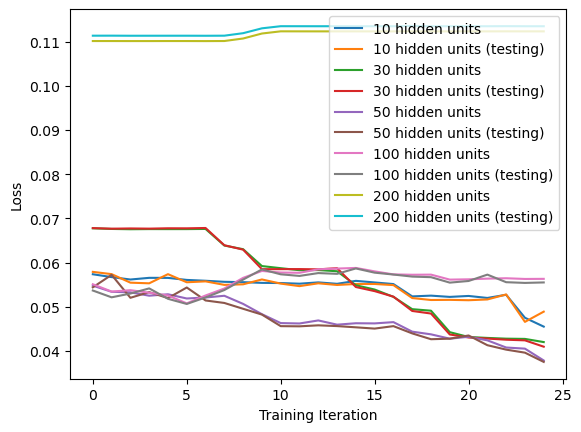

In [116]:
for i in range(len(training_losses)):
  print(f'Plotting for {hidden_layer_sizes[i]} hidden units')
  plt.plot(training_losses[i], label=f'{hidden_layer_sizes[i]} hidden units')
  plt.plot(testing_losses[i], label=f'{hidden_layer_sizes[i]} hidden units (testing)')
plt.xlabel('Training Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

We see that the best performing model has 50 hidden units, it reaches the lowest loss.

In [117]:
# Access 50 hidden unit model
best_model = trained_networks[2]
print(best_model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


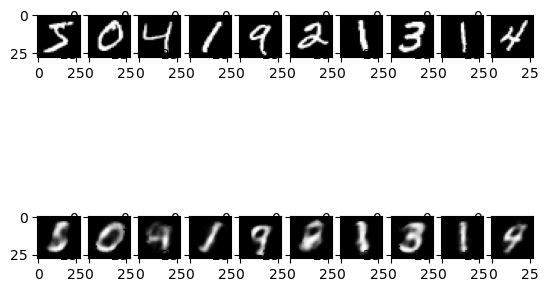

In [118]:
# Plot 10 input and reconstructed images from the training set
best_model.eval()
with torch.no_grad():
  for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_train_tensor[i].reshape(28,28), cmap='gray')
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(best_model(x_train_tensor[i].reshape(1, 784)).reshape(28,28), cmap='gray')

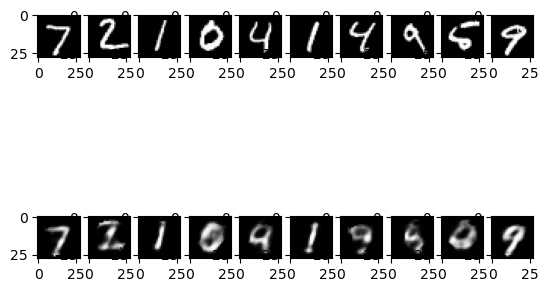

In [119]:
# Plot 10 input and reconstructed images from the test set
best_model.eval()
with torch.no_grad():
  for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_tensor[i].reshape(28,28), cmap='gray')
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(best_model(x_test_tensor[i].reshape(1, 784)).reshape(28,28), cmap='gray')

We find that the autoencoder produces outputs which are better than the hopfield networks above. The digits produced are generally recognizable even though the quality of the outlines are less distinct.

In [129]:
# 3.1.3
# Use best model to look at performance with salt and pepper noise
num_steps = 10 ### Pick a value
prob_flip = torch.linspace(0.01,0.5,num_steps)

mse_values = torch.zeros((num_steps))
for p_idx, p in enumerate(prob_flip):
    print(f'Running test for {p}')
    # Corrupt test data
    noisy_test_data = testing_data.clone()
    flip_mask = torch.rand(noisy_test_data.shape) < p
    # For noise, set to 0 or 1
    noisy_test_data[flip_mask] = torch.randint(0, 2, (noisy_test_data[flip_mask].shape)).float()
    # for each image in the test set, compute the mse
    test_mse = torch.zeros((testing_data.shape[0],))
    for test_idx in range(testing_data.shape[0]):
        true_input = testing_data[test_idx].reshape(1, testing_data.shape[1])
        input_pattern = noisy_test_data[test_idx].reshape(1, testing_data.shape[1])
        reconstructed_img = best_model(input_pattern)
        test_mse[test_idx] = mse(true_input, reconstructed_img)
    average_mse = torch.mean(test_mse)
    mses[p_idx] = average_mse
    pass

Running test for 0.009999999776482582
Running test for 0.06444444507360458
Running test for 0.11888889223337173
Running test for 0.17333334684371948
Running test for 0.22777779400348663
Running test for 0.2822222113609314
Running test for 0.33666664361953735
Running test for 0.3911111056804657
Running test for 0.44555556774139404
Running test for 0.5


tensor([0.0100, 0.0644, 0.1189, 0.1733, 0.2278, 0.2822, 0.3367, 0.3911, 0.4456,
        0.5000])
tensor([1.0845, 1.0832, 1.0833, 1.0844, 1.0871, 1.0891, 1.0887, 1.0909, 1.0879,
        1.0898], grad_fn=<CopySlices>)


Text(0, 0.5, 'MSE')

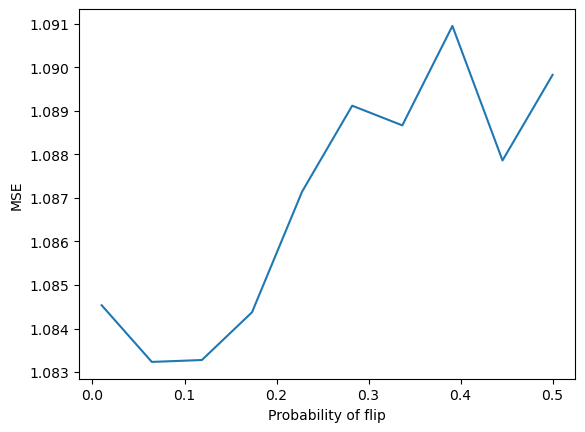

In [130]:
print(prob_flip)
print(mses)
plt.figure()
plt.plot(prob_flip, mses.detach().numpy())
plt.xlabel('Probability of flip')
plt.ylabel('MSE')

Overall, we see that the autoencoder continues to outperform the hopfield networks, the MSE with noise is considerably lower than the hopfield networks.

**3.2 [1 Mark]** Described what you've observed about the results of the autoencoder, compared to the Hopfield networks.

I've observed that the autoencoder consistently outperforms the hopfield network even though it is performing a more difficult task handling all ten digits rather than 3. The image reconstructions are more consistently recognizable than the hopfield network. The autoencode also proved to be more robust when we introduced salt and pepper noise.

**3.3 [1 Marks]** Sensory Preconditioning - Now we are going to look at small datasets. We are going to use the sensory preconditioning protocol, discussed by Gluck and Meyers.

We will also need to construct a data set that performs the preconditioning.  We will break this down into three phases:

1. Do the sensory preconditioning.  Plot the training loss vs number of epochs, describe the resultant behaviour.

In [21]:
# Phase 1: Train the network
## features: s1, s2, context1, context2
# we are teaching this network that these inputs only occur to gether, regardless of the context.
stimuli = np.array([[0,0,0,0],
                    [0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,1,0,0],
                    [1,1,0,0],
                    [1,1,1,0],
                    [1,1,0,1],
                    [1,1,1,1]]).astype(np.float32)

dataset = TensorDataset(torch.from_numpy(stimuli), torch.from_numpy(stimuli))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


epochs = 2000
outputs = []
losses = []

model = Autoencoder(4,3)# Your code here

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)
loss_function = torch.nn.BCELoss()


for epoch in range(epochs):
    for (inp, out) in data_loader:
        
        # Output of Autoencoder
        reconstructed = model(inp)
    
        # Calculating the loss function
        loss = loss_function(reconstructed, out)
        
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
        pass
    outputs.append((epochs, inp, reconstructed))
    pass 

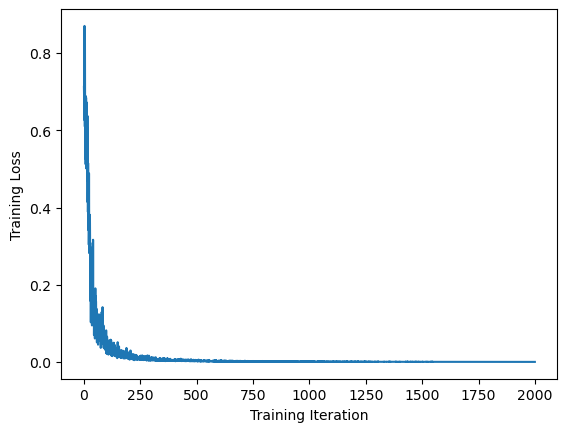

In [22]:
# Plot loss performance.
epoch_markers = np.arange(0, epochs, 0.5)
plt.plot(epoch_markers, losses)
plt.xlabel('Training Iteration')
plt.ylabel('Training Loss')
plt.show()

We find that the system learns very quickly relative to the number of epochs it is trained for. Loss decreases quickly and remains near 0.0 from epochs ~250-2000.

2. Train the conditioned response to one stimulus.  We will train this using simple linear regression where we map the the hidden state to the desired output.  You can reuse the linear regression code from above.

Lets call the features (columns) of the stimuli data as s1, s2, c1, and c2.

In [25]:

conditioning_stimuli = torch.from_numpy(np.array([[0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,0,0,0],
                    [1,0,1,0],
                    [1,0,0,1],
                    [1,0,1,1]]).astype(np.float32))
conditioning_outputs = torch.from_numpy(np.array([[0,0,0,0,1,1,1,1]]).astype(np.float32).T)

conditioning_features = model.encoder(conditioning_stimuli)

def get_weights(features, values, lamb=0.01):
    print('Linear Regression')
    # Apply linear regression to get the weights
    print(f'{features.shape=}')
    print(f'{values.shape=}')
    W = pseudo_inv(features, lamb=lamb) @ values
    print(f'{W.shape=}')
    return W

def evaluate(weights, features):
    print('Evaluate')
    print(f'{weights.shape=}')
    print(f'{features.shape=}')
    outputs = features @ weights
    print(f'{outputs.shape=}')
    return outputs

W = get_weights(conditioning_features, conditioning_outputs)

conditioned_response = evaluate(W, conditioning_features[4:,:])
print(f"{conditioned_response=}")

Linear Regression
features.shape=torch.Size([8, 3])
values.shape=torch.Size([8, 1])
W.shape=torch.Size([3, 1])
Evaluate
weights.shape=torch.Size([3, 1])
features.shape=torch.Size([4, 3])
outputs.shape=torch.Size([4, 1])
conditioned_response=tensor([[1.3049],
        [0.9823],
        [0.6796],
        [0.3586]], grad_fn=<MmBackward0>)


(-0.5, 1.5)

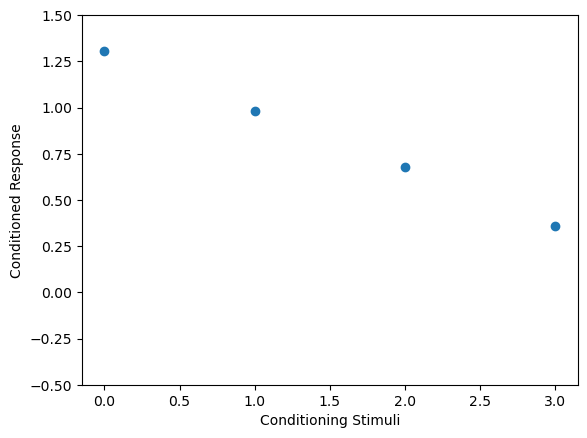

In [26]:
# Plot the conditioned response
response_np = conditioned_response.detach().numpy()
plt.scatter(range(0, len(conditioned_response)), response_np)
plt.xlabel('Conditioning Stimuli')
plt.ylabel('Conditioned Response')
plt.ylim(-0.5, 1.5)

3. Report the strength of the conditioned response to the other stimulus.  Has the network transferred learning from one stimuls to the other?

In [27]:
test_stimuli = torch.from_numpy(np.array([
                    [0,1,0,0],
                    [0,1,1,0],
                    [0,1,0,1],
                    [0,1,1,1]]).astype(np.float32))

testing_features = model.encoder(test_stimuli)

transferred_response = evaluate(W, testing_features)
print(f"{transferred_response=}")


Evaluate
weights.shape=torch.Size([3, 1])
features.shape=torch.Size([4, 3])
outputs.shape=torch.Size([4, 1])
transferred_response=tensor([[1.3881],
        [1.1052],
        [0.8206],
        [0.4617]], grad_fn=<MmBackward0>)


(-0.5, 1.5)

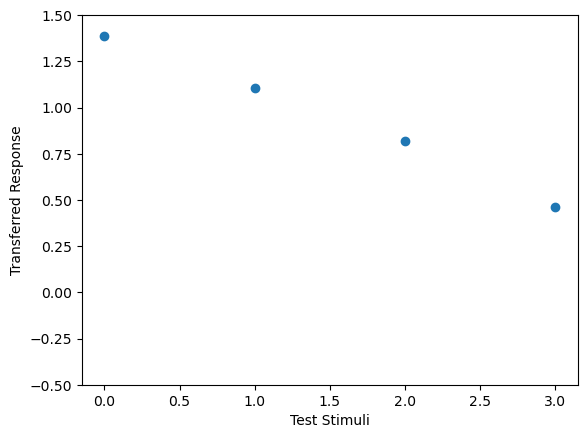

In [28]:
# Plot the transferred response
response_np = transferred_response.detach().numpy()
plt.scatter(range(0, len(transferred_response)), response_np)
plt.xlabel('Test Stimuli')
plt.ylabel('Transferred Response')
plt.ylim(-0.5, 1.5)

Yes, we see that the network has transferred learning form the conditioned stimulus to the other. The responses are similar to those we observed with the trained stimulus.

4. Compare to the response of the system without either of the preconditioned inputs

In [29]:
unconditioned_responses = evaluate(W, conditioning_features[:4,:])
print(f"{unconditioned_responses=}")

Evaluate
weights.shape=torch.Size([3, 1])
features.shape=torch.Size([4, 3])
outputs.shape=torch.Size([4, 1])
unconditioned_responses=tensor([[-0.0845],
        [-0.1598],
        [ 0.0608],
        [-0.0088]], grad_fn=<MmBackward0>)


(-0.5, 1.5)

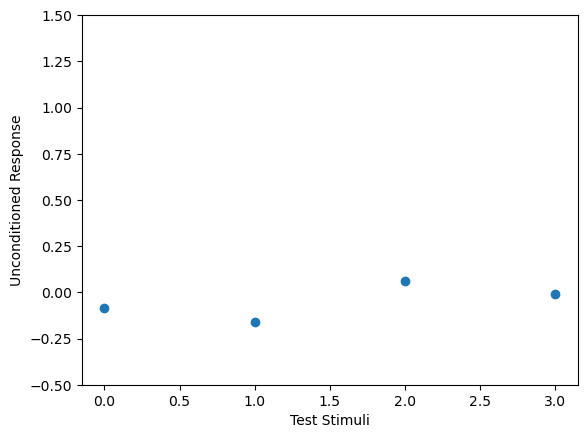

In [30]:
# Plot the unconditioned response
response_np = unconditioned_responses.detach().numpy()
plt.scatter(range(0, len(unconditioned_responses)), response_np)
plt.xlabel('Test Stimuli')
plt.ylabel('Unconditioned Response')
plt.ylim(-0.5, 1.5)

In contrast we see that the system reponse to an input without the preconditioned reponse is much lower. This further reinforces the idea that the behaviour observed earlier was transfer learning, not just a normal output.

5. Plot graphs showing the strength of the response to the conditioned stimuli, the pre-conditioned stimuli, and the unconditioned stimuli
(*i.e.*, s1 = 0, s2 = 0, and context in $\{(0,0),(0,1),(1,0),(1,1)\}$)

response_mu=array([ 0.8313297 ,  0.9438863 , -0.04806477], dtype=float32)
response_std=array([0.40562162, 0.39622712, 0.09523035], dtype=float32)


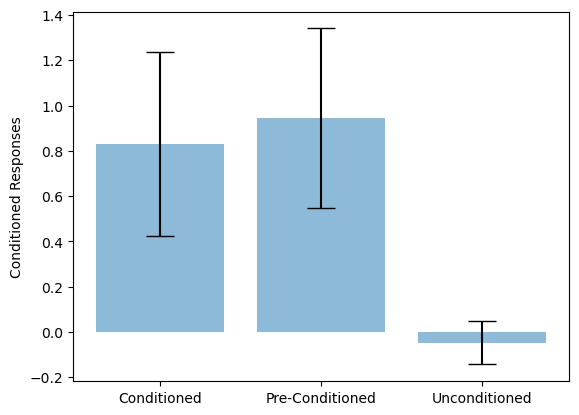

In [31]:
response_mu = torch.tensor([conditioned_response.mean(), transferred_response.mean(), unconditioned_responses.mean()])
response_std = torch.tensor([conditioned_response.std(), transferred_response.std(), unconditioned_responses.std()])

response_mu = response_mu.detach().numpy()
response_std = response_std.detach().numpy()

print(f'{response_mu=}')
print(f'{response_std=}')

fig, ax = plt.subplots()
ax.bar([1,2,3], response_mu, yerr=response_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Conditioned Responses')
ax.set_xticks([1,2,3], labels=['Conditioned', 'Pre-Conditioned', 'Unconditioned'])

**[BONUS]** [1 Mark] Repeat the sensory preconditioning, but use an conditioning stimulus that is not 100\% correlated with the unconditioned stimulus. That is: change phase 2 so that it is not possible to perfectly predict the output.